In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Implementing the Stochastic SIR Model using Gillespie's Algorithm

In this section, we implement the stochastic SIR (Susceptible-Infected-Recovered) model using Gillespie's Direct Algorithm. We will simulate the spread of an infectious disease through a population and explore the five hallmarks of stochastic SIR dynamics:

1. **Variability**
2. **Negative Covariances**
3. **Increased Transients**
4. **Stochastic Resonance**
5. **Extinctions**

---

## Defining Model Parameters

We start by defining the model parameters for our simulations.

In [5]:
# Parameters
beta = 0.3      # Transmission rate
gamma = 0.1     # Recovery rate
N = 1000        # Total population
num_simulations = 100  # Number of stochastic simulations
t_max = 160     # Maximum time


- **`beta`**: The rate at which susceptible individuals become infected.
- **`gamma`**: The rate at which infected individuals recover.
- **`N`**: Total number of individuals in the population.
- **`num_simulations`**: Number of stochastic simulations to run for statistical analysis.
- **`t_max`**: The maximum simulation time.

## Solving the Deterministic SIR Model

We define the time points and initial conditions for the deterministic SIR model to compare with our stochastic simulations.

In [6]:
# Time points for deterministic solution
t_det = np.linspace(0, t_max, 1000)

# Initial conditions
S0 = N - 1
I0 = 10
R0 = 0



- **`t_det`**: Time points at which the deterministic model will be evaluated.
- **`S0`, `I0`, `R0`**: Initial conditions for susceptible, infected, and recovered compartments.


## Implementing Gillespie's Algorithm for the Stochastic SIR Model

We define a function to perform a single stochastic simulation using Gillespie's Direct Algorithm.

In [7]:
# Function to run a single Gillespie simulation
def gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    S_vals = [S]
    I_vals = [I]
    R_vals = [R]

    while t < t_max and I > 0:
        # Calculate rates
        a1 = beta * S * I / N     # Infection rate
        a2 = gamma * I            # Recovery rate
        a0 = a1 + a2              # Total rate

        if a0 == 0:
            break

        # Time to next event
        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        # Determine event
        r2 = np.random.uniform()
        if r2 < a1 / a0:
            # Infection event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

        # Store results
        times.append(t)
        S_vals.append(S)
        I_vals.append(I)
        R_vals.append(R)

    return np.array(times), np.array(S_vals), np.array(I_vals), np.array(R_vals)



- **Infection Event (`S -> I`)**: Occurs at rate $ a_1 = \beta \frac{S \cdot I}{N} $.
- **Recovery Event (`I -> R`)**: Occurs at rate $ a_2 = \gamma I $.
- **Time Advancement**: The time to the next event is exponentially distributed with mean $ \frac{1}{a_0} $, where $ a_0 = a_1 + a_2 $.



## Defining the Deterministic SIR Model

We define the ordinary differential equations (ODEs) for the deterministic SIR model.

In [8]:
# Function for deterministic SIR model
def SIR_ode(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

## Solving the Deterministic Model

We solve the deterministic SIR model using the initial conditions and parameters.


In [9]:

# Solve deterministic SIR model
y0 = [S0, I0, R0]
ret = odeint(SIR_ode, y0, t_det, args=(beta, gamma, N))
S_det, I_det, R_det = ret.T


- **`odeint`**: A function from `scipy.integrate` used to solve the system of ODEs.
- **`S_det`, `I_det`, `R_det`**: Arrays containing the deterministic solution for each compartment over time.

## Running Multiple Stochastic Simulations

We run multiple stochastic simulations to analyze variability and compute statistical properties.

In [10]:

# Lists to store multiple simulation results
I_values = []
S_values = []
R_values = []
time_values = []

# Run multiple Gillespie simulations
for sim in range(num_simulations):
    times, S_vals, I_vals, R_vals = gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max)
    I_values.append(I_vals)
    S_values.append(S_vals)
    R_values.append(R_vals)
    time_values.append(times)


- **Purpose**: Collect data from multiple runs to study the stochastic behavior of the epidemic.

## Aligning Data for Statistical Analysis

Since each simulation may have different time points, we interpolate the data onto a common time grid.

In [11]:
# Align data for statistical analysis
max_len = max(len(tv) for tv in time_values)
time_grid = np.linspace(0, t_max, max_len)

I_interp = np.zeros((num_simulations, max_len))
S_interp = np.zeros((num_simulations, max_len))
R_interp = np.zeros((num_simulations, max_len))

for i in range(num_simulations):
    I_interp[i, :] = np.interp(time_grid, time_values[i], I_values[i])
    S_interp[i, :] = np.interp(time_grid, time_values[i], S_values[i])
    R_interp[i, :] = np.interp(time_grid, time_values[i], R_values[i])



- **Interpolation**: Allows us to compute mean and variance across simulations at consistent time points.

## Computing Statistical Measures

We compute the mean, variance, and covariance of the stochastic simulations.


In [12]:
# Compute statistics
I_mean = np.mean(I_interp, axis=0)
I_var = np.var(I_interp, axis=0)
S_mean = np.mean(S_interp, axis=0)
S_var = np.var(S_interp, axis=0)
cov_SI = np.mean((S_interp - S_mean) * (I_interp - I_mean), axis=0)



- **Purpose**: Understand the variability and correlation in the stochastic dynamics.


## Visualizing the Results

### 1. Variability in Stochastic Simulations

We plot the individual stochastic simulations alongside the deterministic solution.

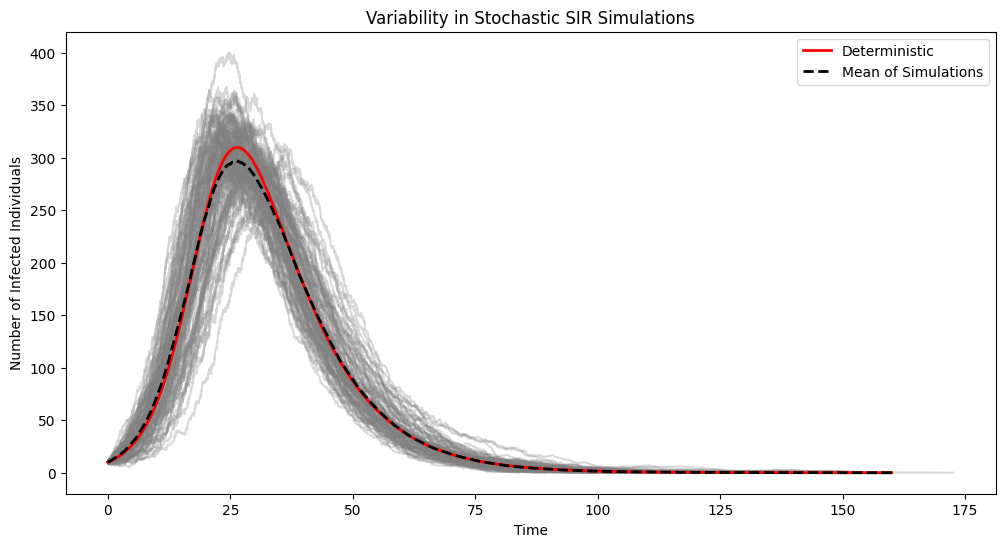

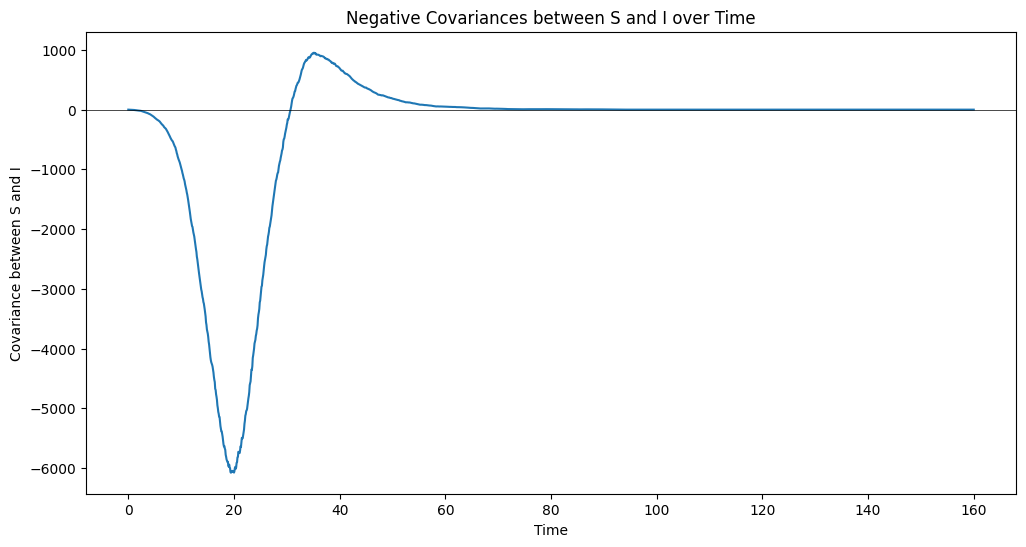

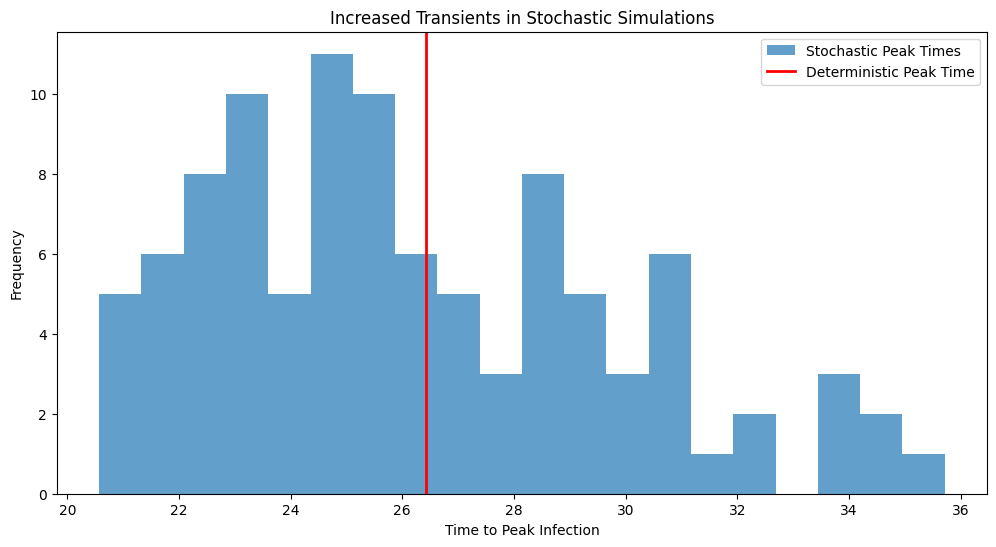

In [13]:
# Plotting results

# 1. Variability: Plot multiple stochastic simulations and compare with deterministic solution
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(time_values[i], I_values[i], color='grey', alpha=0.3)
plt.plot(t_det, I_det, 'r', lw=2, label='Deterministic')
plt.plot(time_grid, I_mean, 'k--', lw=2, label='Mean of Simulations')
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Variability in Stochastic SIR Simulations')
plt.legend()
plt.show()

# 2. Negative Covariances: Plot covariance between S and I over time
plt.figure(figsize=(12, 6))
plt.plot(time_grid, cov_SI)
plt.xlabel('Time')
plt.ylabel('Covariance between S and I')
plt.title('Negative Covariances between S and I over Time')
plt.axhline(0, color='black', lw=0.5)
plt.show()

# 3. Increased Transients: Compare the time to reach peak infection
peak_time_det = t_det[np.argmax(I_det)]
peak_times_stoch = [time_values[i][np.argmax(I_values[i])] for i in range(num_simulations)]

plt.figure(figsize=(12, 6))
plt.hist(peak_times_stoch, bins=20, alpha=0.7, label='Stochastic Peak Times')
plt.axvline(peak_time_det, color='red', lw=2, label='Deterministic Peak Time')
plt.xlabel('Time to Peak Infection')
plt.ylabel('Frequency')
plt.title('Increased Transients in Stochastic Simulations')
plt.legend()
plt.show()


### 4. Stochastic Resonance with Periodic Forcing

We introduce periodic forcing in the transmission rate to study stochastic resonance.

#### Defining Time-Dependent Transmission Rate

In [14]:
# 4. Stochastic Resonance: Introduce periodic forcing in beta
def beta_time(t, beta0, amplitude, frequency):
    return beta0 * (1 + amplitude * np.sin(2 * np.pi * frequency * t))



- **`beta_time`**: Function that modulates `beta` over time with a sinusoidal function.

#### Modifying Gillespie's Algorithm for Time-Dependent Beta


In [15]:

# Modify the Gillespie function to accept time-dependent beta
def gillespie_SIR_forced(beta_func, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    S_vals = [S]
    I_vals = [I]
    R_vals = [R]

    while t < t_max and I > 0:
        current_beta = beta_func(t)
        a1 = current_beta * S * I / N
        a2 = gamma * I
        a0 = a1 + a2

        if a0 == 0:
            break

        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        r2 = np.random.uniform()
        if r2 < a1 / a0:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        times.append(t)
        S_vals.append(S)
        I_vals.append(I)
        R_vals.append(R)

    return np.array(times), np.array(S_vals), np.array(I_vals), np.array(R_vals)


- **Modification**: The function now accepts `beta_func` to allow for time-dependent transmission rates.

#### Running Simulations with Periodic Forcing


In [16]:
# Parameters for periodic forcing
amplitude = 0.5
frequency = 1/50  # One oscillation every 50 time units

# Run multiple simulations with periodic forcing
I_values_forced = []
time_values_forced = []

for sim in range(num_simulations):
    times_f, _, I_vals_f, _ = gillespie_SIR_forced(
        lambda t: beta_time(t, beta, amplitude, frequency), gamma, N, S0, I0, R0, t_max)
    I_values_forced.append(I_vals_f)
    time_values_forced.append(times_f)



- **Purpose**: To observe how stochastic resonance can amplify the system's response to periodic changes in `beta`.

#### Visualizing Stochastic Resonance

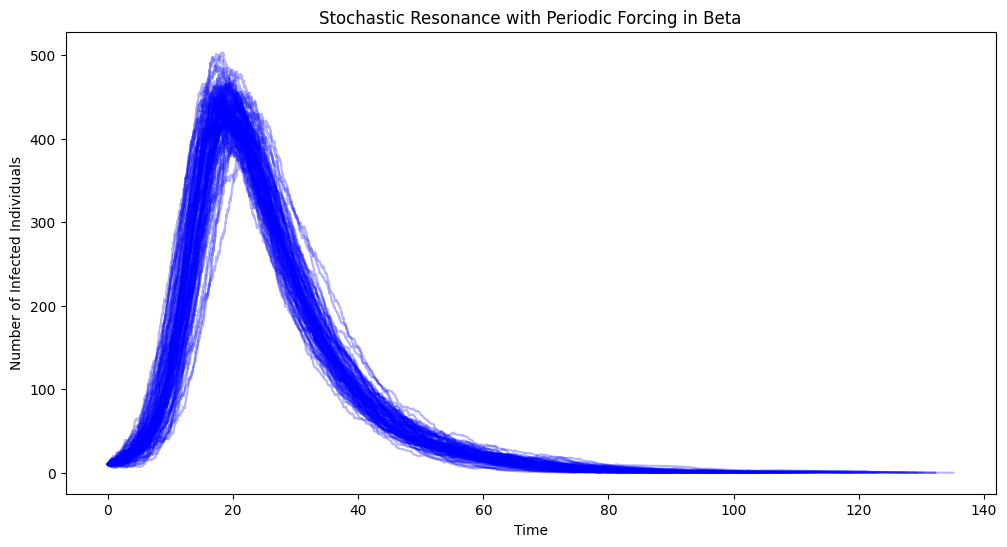

Number of extinctions out of 100 simulations: 100


In [17]:
# Plotting the effect of stochastic resonance
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(time_values_forced[i], I_values_forced[i], color='blue', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Stochastic Resonance with Periodic Forcing in Beta')
plt.show()

# 5. Extinctions: Count the number of simulations where the disease goes extinct
extinctions = sum(1 for I_vals in I_values if I_vals[-1] == 0)
print(f'Number of extinctions out of {num_simulations} simulations: {extinctions}')


In this section, we implement an SIR model with demography, where individuals are born and die at a constant rate $ \mu $. We define both the deterministic and stochastic versions of this model. The deterministic model uses ordinary differential equations (ODEs) with a time-dependent transmission rate $ \beta(t) $ that includes periodic forcing to simulate environmental or seasonal variations. The stochastic model, implemented with the Gillespie algorithm, accounts for discrete infection, recovery, birth, and death events. We use the steady-state values from the deterministic model as initial conditions for the stochastic simulations to investigate how noise and periodic forcing impact disease dynamics over time, particularly in the context of stochastic resonance.


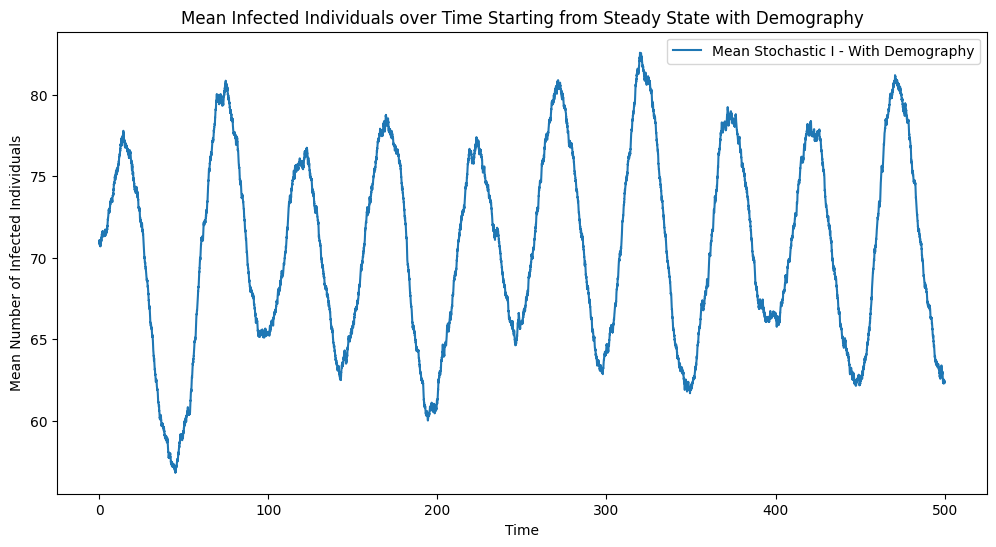

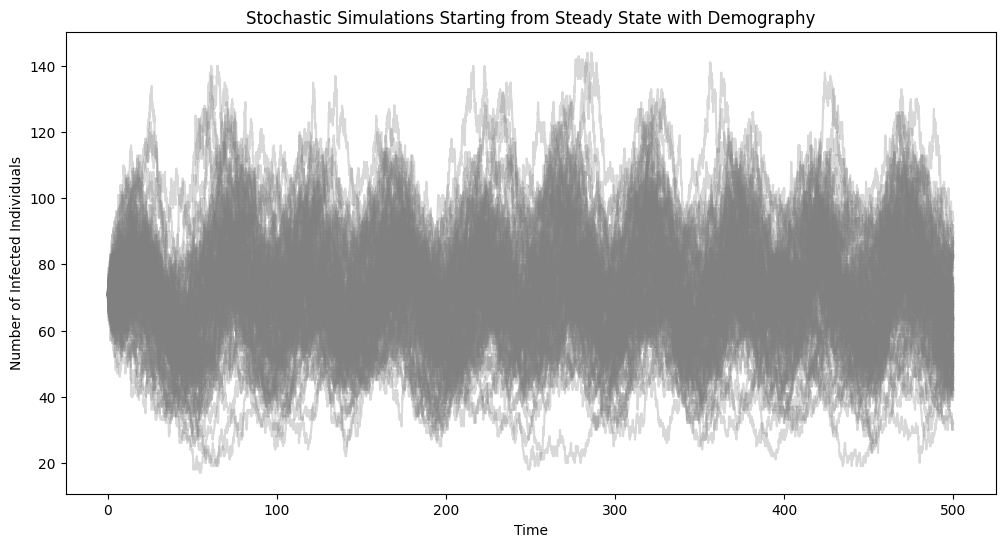

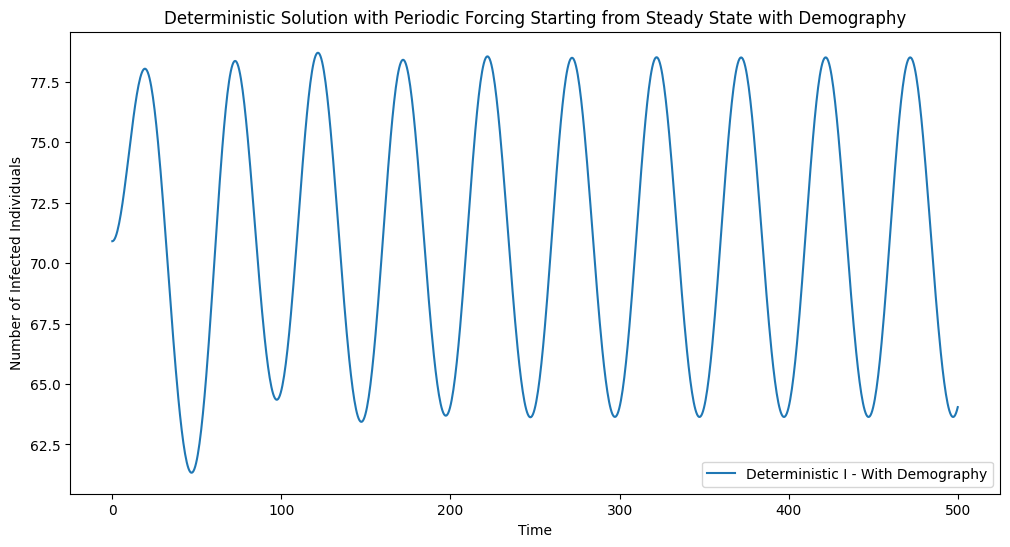

In [18]:
# Define the SIR ODE model with demography
def SIR_ode(y, t, beta, gamma, mu, N):
    S, I, R = y
    # Check if beta is callable (time-dependent)
    if callable(beta):
        beta_t = beta(t)
    else:
        beta_t = beta
    dSdt = mu * N - beta_t * S * I / N - mu * S
    dIdt = beta_t * S * I / N - gamma * I - mu * I
    dRdt = gamma * I - mu * R
    return [dSdt, dIdt, dRdt]

# Define the Gillespie algorithm for the stochastic SIR model with demography and periodic forcing
def gillespie_SIR_demography(beta_func, gamma, mu, N, S0, I0, R0, t_max):
    S = int(round(S0))
    I = int(round(I0))
    R = int(round(R0))
    t = 0

    times = [t]
    S_vals = [S]
    I_vals = [I]
    R_vals = [R]

    while t < t_max:
        current_beta = beta_func(t)
        a_infection = current_beta * S * I / N    # Infection rate
        a_recovery = gamma * I                    # Recovery rate
        a_birth = mu * N                          # Birth rate
        a_death_S = mu * S                        # Death rate in S
        a_death_I = mu * I                        # Death rate in I
        a_death_R = mu * R                        # Death rate in R
        a0 = a_infection + a_recovery + a_birth + a_death_S + a_death_I + a_death_R

        if a0 == 0:
            break

        # Time to next event
        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        # Determine which event occurs
        r2 = np.random.uniform()
        if r2 < a_infection / a0:
            # Infection event
            S -= 1
            I += 1
        elif r2 < (a_infection + a_recovery) / a0:
            # Recovery event
            I -= 1
            R += 1
        elif r2 < (a_infection + a_recovery + a_birth) / a0:
            # Birth event (adds to S)
            S += 1
        elif r2 < (a_infection + a_recovery + a_birth + a_death_S) / a0:
            # Death in S
            S -= 1
        elif r2 < (a_infection + a_recovery + a_birth + a_death_S + a_death_I) / a0:
            # Death in I
            I -= 1
        else:
            # Death in R
            R -= 1

        # Ensure population size remains non-negative
        S = max(S, 0)
        I = max(I, 0)
        R = max(R, 0)

        # Store results
        times.append(t)
        S_vals.append(S)
        I_vals.append(I)
        R_vals.append(R)

    return np.array(times), np.array(S_vals), np.array(I_vals), np.array(R_vals)

# Function to define time-dependent beta with periodic forcing
def beta_time(t, beta0, amplitude, frequency):
    return beta0 * (1 + amplitude * np.sin(2 * np.pi * frequency * t))

# Parameters
beta0 = 0.5       # Baseline transmission rate
gamma = 0.1       # Recovery rate
mu = 0.01         # Birth/Death rate
N = 1000          # Total population
label = 'With Demography'
num_simulations = 100  # Number of stochastic simulations
t_max = 500       # Maximum time for simulations

# Parameters for periodic forcing
amplitude = 0.1   # Small amplitude to simulate accumulation of resonance
frequency = 1/50  # Periodic forcing frequency

# Solve deterministic SIR model over a longer time to reach steady state
t_det_long = np.linspace(0, t_max * 2, 2000)  # Longer time
S0_det = N - 1
I0_det = 1
R0_det = 0
y0_det = [S0_det, I0_det, R0_det]
ret = odeint(SIR_ode, y0_det, t_det_long, args=(beta0, gamma, mu, N))
S_det_long, I_det_long, R_det_long = ret.T

# Get steady-state values from the deterministic model
S_ss = S_det_long[-1]
I_ss = I_det_long[-1]
R_ss = R_det_long[-1]

# For stochastic simulations, ensure I0 is at least 1
I0 = max(1, int(round(I_ss)))
R0 = int(round(R_ss))
S0 = N - I0 - R0

# For the deterministic model with periodic forcing starting from steady state
t_det = np.linspace(0, t_max, 1000)
beta_func = lambda t: beta_time(t, beta0, amplitude, frequency)
y0_ss = [S_ss, I_ss, R_ss]
ret_forced = odeint(SIR_ode, y0_ss, t_det, args=(beta_func, gamma, mu, N))
S_det, I_det, R_det = ret_forced.T

# Lists to store multiple stochastic simulation results
I_values = []
S_values = []
time_values = []

# Run multiple stochastic simulations starting from steady state
for sim in range(num_simulations):
    times, S_vals, I_vals, _ = gillespie_SIR_demography(
        beta_func, gamma, mu, N, S0, I0, R0, t_max)
    I_values.append(I_vals)
    S_values.append(S_vals)
    time_values.append(times)

# Align data for statistical analysis
max_len = max(len(tv) for tv in time_values)
time_grid = np.linspace(0, t_max, max_len)

I_interp = np.zeros((num_simulations, max_len))
S_interp = np.zeros((num_simulations, max_len))

for i in range(num_simulations):
    I_interp[i, :] = np.interp(time_grid, time_values[i], I_values[i])
    S_interp[i, :] = np.interp(time_grid, time_values[i], S_values[i])

# Compute statistics
I_mean = np.mean(I_interp, axis=0)
I_var = np.var(I_interp, axis=0)
S_mean = np.mean(S_interp, axis=0)
cov_SI = np.mean((S_interp - S_mean) * (I_interp - I_mean), axis=0)

# Plotting results

# 1. Plot mean of I over time for stochastic simulations starting from steady state
plt.figure(figsize=(12, 6))
plt.plot(time_grid, I_mean, label=f'Mean Stochastic I - {label}')
plt.xlabel('Time')
plt.ylabel('Mean Number of Infected Individuals')
plt.title('Mean Infected Individuals over Time Starting from Steady State with Demography')
plt.legend()
plt.show()

# 2. Plot multiple stochastic simulations
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(time_values[i], I_values[i], color='grey', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Stochastic Simulations Starting from Steady State with Demography')
plt.show()

# 3. Plot deterministic solution with periodic forcing
plt.figure(figsize=(12, 6))
plt.plot(t_det, I_det, label=f'Deterministic I - {label}')
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Deterministic Solution with Periodic Forcing Starting from Steady State with Demography')
plt.legend()
plt.show()


### Footer

The results of the simulations are displayed in three plots. First, we show the mean infected population over time across multiple stochastic simulations starting from the steady state, illustrating the effect of noise and periodic forcing on disease dynamics. The second plot visualizes individual stochastic trajectories to highlight the variability introduced by stochastic events. Lastly, we present the deterministic solution with periodic forcing, serving as a baseline for comparison with the stochastic results. Together, these plots demonstrate how periodic forcing and stochastic effects combine to produce fluctuations around the steady state, offering insights into the impact of demographic changes on epidemic behavior.

N=500, R0=1.00, Extinction Probability=1.000
N=500, R0=1.04, Extinction Probability=1.000
N=500, R0=1.07, Extinction Probability=1.000
N=500, R0=1.11, Extinction Probability=1.000
N=500, R0=1.15, Extinction Probability=1.000
N=500, R0=1.19, Extinction Probability=1.000
N=500, R0=1.23, Extinction Probability=1.000
N=500, R0=1.26, Extinction Probability=1.000
N=500, R0=1.30, Extinction Probability=1.000
N=500, R0=1.34, Extinction Probability=1.000
N=500, R0=1.38, Extinction Probability=1.000
N=500, R0=1.41, Extinction Probability=1.000
N=500, R0=1.45, Extinction Probability=1.000
N=500, R0=1.49, Extinction Probability=1.000
N=500, R0=1.52, Extinction Probability=1.000
N=500, R0=1.56, Extinction Probability=1.000
N=500, R0=1.60, Extinction Probability=1.000
N=500, R0=1.64, Extinction Probability=1.000
N=500, R0=1.67, Extinction Probability=1.000
N=500, R0=1.71, Extinction Probability=1.000
N=500, R0=1.75, Extinction Probability=1.000
N=1000, R0=1.00, Extinction Probability=1.000
N=1000, R

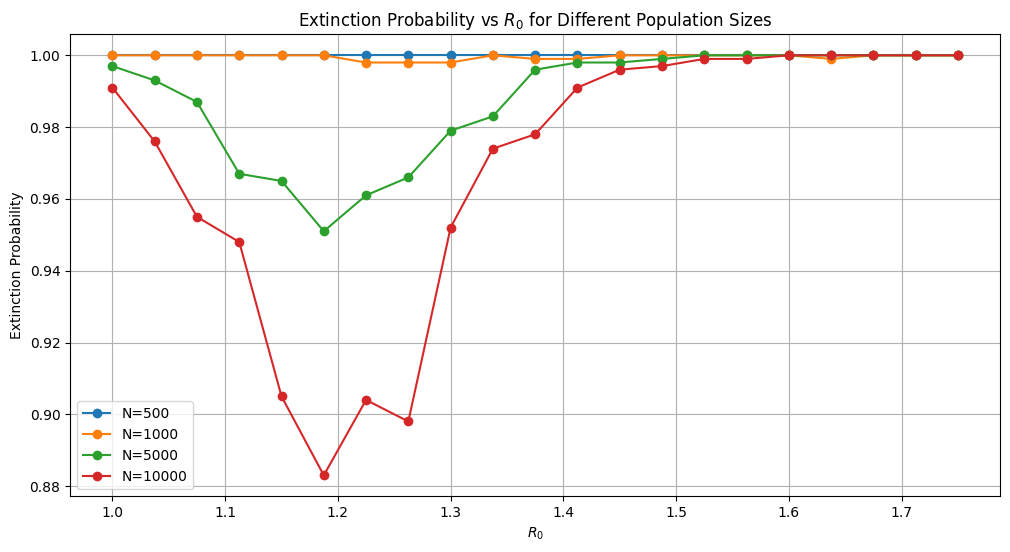

In [18]:
# Gillespie algorithm function to check for extinction
def gillespie_SIR_extinction(beta, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    while t < t_max:
        if I == 0:
            # Extinction occurred
            return True
        # Calculate rates
        a1 = beta * S * I / N  # Infection rate
        a2 = gamma * I         # Recovery rate
        a0 = a1 + a2           # Total rate

        if a0 == 0:
            break

        # Time to next event
        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        # Determine event
        r2 = np.random.uniform()
        if r2 < a1 / a0:
            # Infection event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

    # If simulation ends without I reaching 0, extinction did not occur
    return False

# Parameters
gamma = 0.1  # Fixed recovery rate
t_max = 500
n_simulations = 1000  # Number of simulations per parameter set
I0 = 1  # Initial number of infected individuals

# R0 and N values to test
R0_values = np.linspace(1.0, 1.75, 21)  # From 1.0 to 3.0 in steps of 0.1
N_values = [500, 1000, 5000, 10000]

# Store results
extinction_probabilities = {}

for N in N_values:
    extinction_probabilities[N] = []
    S0 = N - I0
    for R0 in R0_values:
        beta = R0 * gamma  # Adjust beta to get desired R0
        extinctions = 0
        for _ in range(n_simulations):
            extinct = gillespie_SIR_extinction(beta, gamma, N, S0, I0, 0, t_max)
            if extinct:
                extinctions += 1
        P_extinct = extinctions / n_simulations
        extinction_probabilities[N].append(P_extinct)
        print(f"N={N}, R0={R0:.2f}, Extinction Probability={P_extinct:.3f}")

# Plotting the results
plt.figure(figsize=(12, 6))
for N in N_values:
    plt.plot(R0_values, extinction_probabilities[N], marker='o', label=f'N={N}')
plt.xlabel('$R_0$')
plt.ylabel('Extinction Probability')
plt.title('Extinction Probability vs $R_0$ for Different Population Sizes')
plt.legend()
plt.grid(True)
plt.show()
